# Introduction to PyTorch

In this notebook, we will introduce the main concepts of the deep learning library _PyTorch_, and in particular:
* [How to work with tensors](#pyTorch-tensors-and-numpy-arrays)
* [Set up your GPU for parallel computation](#computation-devices)
* [How to load data](#loading-data)
* [How to define (and save) a neural network model](#model-definition-and-saving)
* [Implement a training algorithm](#training-loop)
* [Ideas for self-led exercises](#take-this-notebook-further)

We will test our code on the classic MNIST digit recognition benchmark


In [ ]:
# Let's first install numpy and matplotlib if not present,
%pip install numpy matplotlib

# Next install pytorch - see https://pytorch.org/get-started/locally/ to generate 
# the install command suited to your platform.
# Or, the command below would also work, at the cost of installing CUDA-related packages that 
# are not needed if you don't have a GPU
%pip install torch torchvision

# Finally install torcheval, which facilitates the computation of some metrics (e.g., accuracy).
%pip install torcheval 

In [1]:
# Import pytorch and numpy libraries
import torch
import torch.nn as nn
import numpy as np

## PyTorch tensors (and numpy arrays)

* In deep learning, we need to deal with multidimensional data.
* This kind of data is represented in data structures known as _tensors_, i.e., multi-dimensional array
    * For instance, a batch of 64 B/W images with resolution 40x40 is tensor with a size of `[64,40,40]`, or
    * a batch of 32 colour videos, where each video has 1000 frames and resolution of 600x600 can be stored with a tensor of size `[32,1000,600,600,3]` (where 3 it's because we have 3 colour channels)
    * moreover, intermediate (hidden) NN features are multi-dimensional
        * e.g., the feature map produced by a convolutional layer has size `[batch_size, num_channels, x_resolution, y_resolution]`

In [2]:
# a Python-native way of generating multi-dimensional data is through list of lists 
list_data = [[0.0,2.0], [1.0, 3]]
list_data # to display it in the output

[[0.0, 2.0], [1.0, 3]]

In [3]:
# You can convert a Python list into a numpy array
# Note that this method is slow and numpy constructors should be used instead
np_data = np.array(list_data)
np_data

array([[0., 2.],
       [1., 3.]])

In [4]:
# shape attribute gives the size of the numpy array
print('Size of the array is: '+str(np_data.shape))
# dtype attribute gives the data type (integer in this case)
print('Data type of the array is: '+str(np_data.dtype))

Size of the array is: (2, 2)
Data type of the array is: float64


* PyTorch tensors are very similar to numpy arrays, but they have extra capabilities (mostly to enable gradient computation)
* Below we create a PyTorch tensor from a numpy array

In [5]:
torch_data = torch.from_numpy(np_data)
torch_data

tensor([[0., 2.],
        [1., 3.]], dtype=torch.float64)

Using `torch.from_numpy` means that the tensor and the numpy array will share the same memory, i.e., changes in the tensor will be reflected in the array

In [6]:
# let's modify one entry of the tensor
torch_data[0,1] = 17
print('torch data:\n'+str(torch_data)+'\n')
# the array also changed
print('np data:\n'+str(np_data)) 

torch data:
tensor([[ 0., 17.],
        [ 1.,  3.]], dtype=torch.float64)

np data:
[[ 0. 17.]
 [ 1.  3.]]


And viceversa

In [7]:
np_data[0,1] = 9
print('np data:\n'+str(np_data)+'\n') 
# the tensor also changed
print('torch data:\n'+str(torch_data)) 

np data:
[[0. 9.]
 [1. 3.]]

torch data:
tensor([[0., 9.],
        [1., 3.]], dtype=torch.float64)


If we want to create a tensor from a numpy array without sharing the memory, we can use the syntax below

In [8]:
torch_data_copy = torch.tensor(np_data)
torch_data_copy[0,1] = 10
print('torch data:\n'+str(torch_data_copy)+'\n')
# the array didn't change in this case
print('np data:\n'+str(np_data)) 

torch data:
tensor([[ 0., 10.],
        [ 1.,  3.]], dtype=torch.float64)

np data:
[[0. 9.]
 [1. 3.]]


### Gradients

* Here we will briefly see how to compute gradients and how these are stored in the tensor
* To do so, we create a simple linear operation $w\cdot x$
* We want to compute the gradient of $w\cdot x$ w.r.t. weights $w$. So we use the parameter `requires_grad` to tell PyTorch for which tensor gradients are required

In [9]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=False)
print(x)
w = torch.tensor([-0.5, 0.5, 1.5], requires_grad=True)
print(w)


tensor([1., 2., 3.])
tensor([-0.5000,  0.5000,  1.5000], requires_grad=True)


In [10]:
# now lets compute our output (dot product of w and x)
y = sum(w*x)
# we see that PyTorch keeps track of the operation to `reverse` during the backward pass
print(y) 

tensor(5., grad_fn=<AddBackward0>)


In [11]:
# now let's do the backward pass (gradient computation)
y.backward()
# now w.grad attribute will give us the gradient of y w.r.t w
print(w.grad)
# but x.grad returns none because we told PyTorch not to compute gradients w.r.t. x
print(x.grad)

tensor([1., 2., 3.])
None


Note that, by default, PyTorch keeps gradient info only for the leaf nodes in the computation graph, not for intermediate nodes -- for efficiency reasons
* one can use `retain_grad()` to keep this info for any given tensor in the graph


### Reshaping and manipulating tensors

* It is often useful to reshape the content of a tensor
    * e.g., when a picture (matrix) needs to be flattened into a vector
* Below are examples showing some common operations to do so: `view`, `flatten`, `squeeze`
* We will also see how to reshape data by swapping dimensions using  `permute`


In [12]:
# creates a tensor of size [2,4,3] containing random numbers from a standard normal
x = torch.randn(2, 4, 3)
# shape attribute gives size of the tensor
print('Size of tensor is: '+str(x.shape))

Size of tensor is: torch.Size([2, 4, 3])


In [13]:
# Now we want to reshape the tensor into a 2-dimensional one, 
# by combining the last two dimensions and keeping the first one intact
y = x.view(2, 12)
print(y.shape)

# or we can add an extra dimension
y = x.view(2,2,2,3)
print(y.shape)

# Note that dimensions need to be compatible, 
# e.g., we can reshape into a matrix of size 2,11
# (formally, the product of the dimensions must be preserved)
x.view(2,11) # this will throw an error

torch.Size([2, 12])
torch.Size([2, 2, 2, 3])


RuntimeError: shape '[2, 11]' is invalid for input of size 24

In [14]:
# A useful thing is to use the 'special' size -1, 
# if *one* of the dimensions is specified to -1, then pytorch will infer this automatically
print(x.view(2,-1).shape) # equivalent to (2,12)
print(x.view(-1,6).shape) # equivalent to (4,6)
print(x.view(2,-1,2).shape) # equivalent to (2,6,2)


torch.Size([2, 12])
torch.Size([4, 6])
torch.Size([2, 6, 2])


**Important** views don't create a copy of the tensor, i.e., the view of a tensor shares the memory with the original tensor

In [15]:
# creates a tensor of all ones of size (2,1,3) (and where data is float)
x = torch.ones(2,1,3, dtype=torch.float)
# 1-d tensor of size 6
x_view = x.view(-1)

# equivalent to using 
# x_view = torch.flatten(x)

x_view[4] = 0
print('tensor view: '+str(x_view))
print('base tensor: '+str(x)) 

tensor view: tensor([1., 1., 1., 1., 0., 1.])
base tensor: tensor([[[1., 1., 1.]],

        [[1., 0., 1.]]])


In [16]:
# Often it happens to have tensors where some dimensions have size 1 (i.e., they are redudant): 
# the squeeze function gets rid of those dimensions (without losing data ofc)

# creates a tensor of all ones of size (2,1,3) (and where data is float)
x = torch.ones(2,1,3, dtype=torch.float)
x_squeeze = torch.squeeze(x)
print('size before squeeze: '+str(x.shape))
print('size after squeeze: '+str(x_squeeze.shape))

# note that the squeezed tensor is a view and so it will share the memory with the original one
x_squeeze[1,2] = 0
print('value in squeezed tensor: '+str(x_squeeze[1,2]))
print('value in original tensor: '+str(x[1,0,2])) 

size before squeeze: torch.Size([2, 1, 3])
size after squeeze: torch.Size([2, 3])
value in squeezed tensor: tensor(0.)
value in original tensor: tensor(0.)


In [17]:
# permute returns a view of the tensor after applying an arbitrary re-ordering of the dimensions
# (being a view it shares memory with base tensor)

# here is a 3-d random tensor of size 2,4,6
x = torch.randn(2,4,6)
print('base tensor: '+ str(x))
# this means: first dimension (0) now becomes the 2nd; second dimension (1) becomes first; third dimension (2) stays third
x_permu = torch.permute(x,[1,0,2]) 
print('permuted tensor: '+ str(x_permu))


base tensor: tensor([[[ 0.0982, -1.0404,  0.3801,  0.0413,  0.3290,  2.1115],
         [ 1.0670, -0.3697, -1.4197, -0.7463,  0.6813,  0.7257],
         [ 0.3548, -1.4585,  0.8710,  0.5355, -0.0140,  0.7142],
         [ 0.3457,  0.5222, -1.4767,  1.8235, -1.2827, -1.1189]],

        [[-0.9354,  1.1091, -0.1466,  1.0905, -0.7109, -0.4431],
         [-0.2183,  0.6157, -0.7149,  0.9130,  1.4787, -0.5155],
         [ 1.9176,  1.4264,  0.1313,  0.1305, -0.2488,  0.4186],
         [-0.9612,  0.2950,  2.0149,  1.0078,  0.0660,  1.0427]]])
permuted tensor: tensor([[[ 0.0982, -1.0404,  0.3801,  0.0413,  0.3290,  2.1115],
         [-0.9354,  1.1091, -0.1466,  1.0905, -0.7109, -0.4431]],

        [[ 1.0670, -0.3697, -1.4197, -0.7463,  0.6813,  0.7257],
         [-0.2183,  0.6157, -0.7149,  0.9130,  1.4787, -0.5155]],

        [[ 0.3548, -1.4585,  0.8710,  0.5355, -0.0140,  0.7142],
         [ 1.9176,  1.4264,  0.1313,  0.1305, -0.2488,  0.4186]],

        [[ 0.3457,  0.5222, -1.4767,  1.8235, -1.2

### Computation devices

* `torch` includes helper functions to load tensors into GPU (if available) in such a way that computation can be parallelized
* GPU devices id are of the form `cuda:0`, `cuda:1`, and etc. If no GPU is available, then the id is `cpu`
* when dealing with GPU tensors, PyTorch automatically use the "parallel" versions of all tensor operations

In [18]:
# let's first see if a cuda GPU is available
print('Is cuda GPU available? '+str(torch.cuda.is_available()))
# or, similarly, we can get the number of cuda GPUs
print('the number of GPUs available is '+str(torch.cuda.device_count()))
# of course, if running on CPU, you will get False and 0


Is cuda GPU available? False
the number of GPUs available is 0


In [19]:
# let's select the first GPU device if available, or cpu o/w
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


* if we want to store a tensor in the GPU memory for parallelization (when available), then we need to specify the correct device attribute
    * by default a new tensor is always stored on GPU
* if only running on cpu, all of this doesn't really matter as we will be using the cpu memory
* Or, we can "move" a cpu tensor into a GPU with the `to` function

In [20]:
tensor_on_gpu = torch.tensor([1,2,3], device=device)
print(tensor_on_gpu.device)

cpu


In [21]:
# creates a tensor on cpu
tensor_on_cpu = torch.tensor([1,2,3])
tensor_on_gpu = tensor_on_cpu.to(device)
print(tensor_on_gpu.device)

cpu


## Loading data
* We will start by loading the classic MNIST digit recognition dataset from the `torchvision` package
* Then, we will see how to use `torch`'s `DataLoader` to load the data and prepare it for training

In [22]:
# first let's import the required libraries
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
# image transformation utilities
from torchvision import transforms
import torchvision.utils

In [23]:
# Load MNIST dataset:
# The first argument is the path where data will be downloaded 
# We set the parameter train=True, meaning we are interested in training data (as opposed to test/validation)
# download=True downloads the data (skips if already present in path)
# transform applies a (series of) transformation(s) to the data. 
# ToTensor converts into tensor data and normalize it as a float between 0 and 1
train_data = MNIST('data', train=True, download=True, transform=transforms.ToTensor())

# with a similar syntax we initialize the validation dataset (note that train=False here)
val_data = MNIST('data', train=False, download=True, transform=transforms.ToTensor())

100.0%
100.0%
100.0%
100.0%


In [24]:
# the len function will tell us the size of the dataset
print('Dataset size: '+str(len(train_data))) # we have 60,000 training points

Dataset size: 60000


In [25]:
# We can use indexing notation to access items of a torch Dataset.
# Here we read the 478-th datapoint as a tuple (input,output)
# In this case, img is the tensor picture, and label is a int
img, label = train_data[477]
print(img.shape) # MNIST pictures are grey-scale and 28x28 
print(label)


torch.Size([1, 28, 28])
2


Let's now introduce a helper function to show an image

In [27]:
# For this, let's load pyplot, a very useful library for plotting
import matplotlib.pyplot as plt

# Helper function to show an image
# It takes in input a pic stored as a tensor
def plot_MNIST_pic(img, true_label=None, predicted_label=None):
    # suppress unnecessary dimensions
    img=torch.squeeze(img)
    # converts the image tensor into a numpy array
    # clone makes a copy so that memory is not shared
    # force=True detaches the tensor from the computational graph and copies it into cpu memory before transforming into numpy
    npimg = img.clone().numpy(force=True)
    title_str = '' if true_label is None else 'Label: '+str(true_label)
    title_str += '' if predicted_label is None else '. Predicted: '+str(predicted_label)
    plt.title(title_str)
    plt.imshow(npimg, cmap="Greys")

# Helper function to show a batch of images
def plot_MNIST_batch(img_batch, nrows=8):
    # create grid of images, with given number of rows
    img_grid = torchvision.utils.make_grid(img_batch, nrow=nrows)
    # the shape will be [3, 28*n_rows, 28*n_cols] where 3 stand for the RGB color channels 
    # (in grayscale pics like mnist, all channels are equal) 
    print(img_grid.shape) 
    # to make it work with plt.imshow, the channel dim must be the last
    img_grid = torch.permute(img_grid,[1,2,0])
    plt.title("MNIST Images")
    plt.imshow(img_grid.numpy(), cmap="Greys")

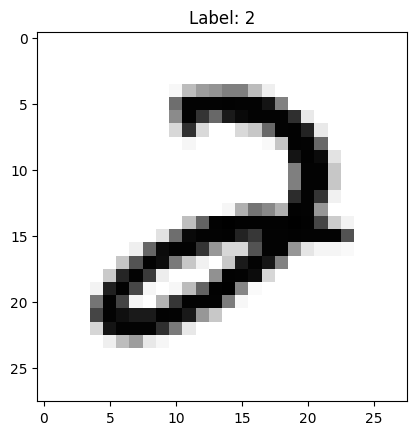

In [28]:
plot_MNIST_pic(img, label)

* The best practice is to pass the data to a `DataLoader` object, instead of indexing
* torch's dataloaders are iterable, allows loading the data in (mini-)batches and support shuffling
    * data is reshuffled at every epoch, where one epoch corresponds to a full scan of the dataset (using multiple batches)
* next, we define a dataloader passing to it our training data

In [29]:
# Our dataloader loads batches of size 64 at every iteration
# and shuffles the data at every epoch 
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Similar code for validation data
# only that validation data needs no shuffling
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)


In [30]:
# The dataloader provides an iterator object, 
# which returns (in this case) 64 points at every `next` call 
dataiter = iter(train_loader)
images, labels = next(dataiter)
print('Shape of inputs in minibatch: '+ str(images.shape))
# note that the dataloader automatically converts labels from `int` to torch tensors
print('Type of label object: '+str(type(labels))) 

Shape of inputs in minibatch: torch.Size([64, 1, 28, 28])
Type of label object: <class 'torch.Tensor'>


torch.Size([3, 242, 242])


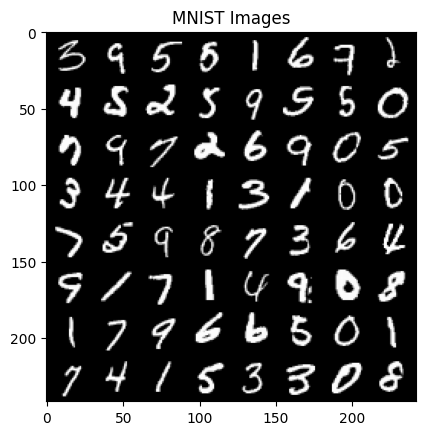

In [31]:
# Whenever `iter` (or `enumerate`) is called, the dataset is reshuffled
# 
# Here we plot all the MNIST digits in the first batch after a new `iter` call.
# If you run this cell twice, you will see different plots
dataiter = iter(train_loader)
images, labels = next(dataiter)

plot_MNIST_batch(images)


## Model definition and saving

* We now define a shallow NN model with one hidden layer only. 
* We'll do this using both the "inline" `Sequential` syntax and the subclass approach (as seen in the video)
* we will also see how to save and load a model

In [32]:
# Define model inline
model = nn.Sequential(
    # The first hidden layer takes in input a flattened vector of MNIST pictures
    # (of size 28*28=784) and produces a feature vector of size 64
    nn.Linear(784, 32), 
    nn.ReLU(),
    # the output layer takes in input the previous feature vector and produces 10 outputs 
    nn.Linear(32, 10)
)

In [33]:
# Define model by extending torch’s nn.Module 
# Here, the size of the hidden layer is passed as a constructor parameter
class MNISTNet(nn.Module): 
    def __init__(self, hidden_dim=32):
        super(MNISTNet,self).__init__()
        self.layer1 = nn.Linear(784, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 10)

    def forward(self,x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x 

model = MNISTNet()
# move model's parameters to (GPU) device
model = model.to(device)


In [34]:
# When a model is created, its weights are initialized (at random)
# 
# We can peek at them using the `layers` attributes we attached to MNISTNet
print(model.layer1.weight)

Parameter containing:
tensor([[ 2.2745e-02, -5.1359e-03,  2.2160e-02,  ..., -1.9395e-02,
          1.1135e-02,  1.1064e-02],
        [-2.4565e-02,  1.9703e-03,  1.8094e-02,  ...,  3.0838e-02,
          1.4849e-02, -9.5203e-03],
        [ 2.0897e-02, -2.5987e-02, -1.4239e-02,  ...,  1.9265e-02,
         -6.9322e-03,  2.2975e-02],
        ...,
        [-2.2131e-02, -1.7756e-02,  1.7220e-02,  ..., -2.4217e-05,
          1.0105e-02, -1.7999e-02],
        [ 1.2062e-02,  2.7775e-02,  1.4535e-02,  ...,  2.3023e-02,
         -8.0152e-03, -8.5776e-03],
        [ 6.8322e-03, -3.4357e-02,  3.4396e-02,  ..., -2.6957e-02,
         -2.9730e-02,  4.6434e-03]], requires_grad=True)


In [35]:
# Later we will pass parameters to the optimizer using the parameters() function
# which returns an iterator over the model's parameters
for param in model.parameters():
    print(type(param), param.size()) # this will print sizes of both weights and biases

<class 'torch.nn.parameter.Parameter'> torch.Size([32, 784])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 32])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


In [36]:
# Let's now save and reload our model
# This is done using the state_dict() function, 
# which returns a dictionary object with all learnable parameters
params_dict = model.state_dict()
# save to file mnist-torch-model-untrained.pt
torch.save(model.state_dict(), 'mnist-torch-model-untrained.pt')

# Load pt file into model (model object must have compatible architecture ofc)
# Parameter map_location specifies where to store the model
# This ensures that model parameters are loaded into the correct device 
# (which may be different from the device from which they were originally stored)
model.load_state_dict(
    torch.load('mnist-torch-model-untrained.pt', map_location=device))

<All keys matched successfully>

## Training loop
* Let's now define a basic training loop
    * we train for a fixed number of epochs
    * at every epoch we keep track of training and validation loss and accuracy
    * and we will keep track of the model with best validation accuracy
    * before processing, every batch will be copied to gpu (if available)
* this is somewhat boilerplate code but it's useful to being able to do this manually and personalize it to your needs
* but first, we'll need to define our loss function and optimizer
    * as for the loss function, we will use the _cross entropy_ loss, which roughly:
        1. Applies a softmax to the (10) model outputs, obtaining (pseudo-)probabilities for each class
        2. computes the log product of the model predicted probabilities of the true classes (we want to maximize this value)


**Note on saving model checkpoints**
Here we save only the best model so far, but it's also good practice to save the model at each epoch so one can resume the training at any previous checkpoint

In [37]:
# number of full sweeps of the train data
n_epochs = 4 

# our optimizer; adam is one of the best (we'll run it with default hyper-parameters)
optimizer = torch.optim.Adam(model.parameters())

# cross entropy loss
loss_fn = nn.CrossEntropyLoss()

In [38]:
# we will use the torcheval library to compute accuracy
from torcheval.metrics import MulticlassAccuracy

train_accuracy_fn = MulticlassAccuracy()
val_accuracy_fn = MulticlassAccuracy()

# Store training losses and accuracies for every batch
# len(train_loader) is the number of batches for every epoch
training_losses = np.zeros([len(train_loader)*n_epochs])
training_accuracies = np.zeros([len(train_loader)*n_epochs])

# store validation accuracy for every epoch
val_accuracies = np.zeros([n_epochs])

# keep track of best validation accuracy and best model
best_accuracy = 0

# training loop
for epoch in range(n_epochs):
    # iterate over all the dataloader's mini-batches
    for i, (inputs, labels) in enumerate(train_loader):
        # move to GPU memory
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Flatten input images.
        # Note that we don't use the `flatten` function because 
        # we need to keep the first dimension (indicating the batch sample)
        inputs = inputs.view(-1, 784)
        
        # Zero the gradients
        # This is important to do at every step, o/w gradients will accumulate
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        # Backward pass (gradient computation) 
        loss.backward()
        # updates the parameters
        optimizer.step()
        
        # log the loss value (item() returns a python scalar for one-element tensors)
        training_losses[epoch * len(train_loader) + i] = loss.item() 

        # Compute accuracy of the batch.
        # 
        # update() updates the accuracy computation with new data 
        train_accuracy_fn.update(outputs, labels)
        # compute() compute accuracy with the current data
        training_accuracies[epoch * len(train_loader) + i] = train_accuracy_fn.compute() 
        # resets the data used to compute accuracy (we want to compute it per-batch)
        train_accuracy_fn.reset()
        
        # display some progress (every 200 batches)
        # optional, you can comment out
        # if i % 200 == 0:
        #     print(f'Epoch {epoch + 1}, batch {i+1} of {len(train_loader)}')

    print(f'Epoch {epoch + 1} training complete')

    # We now use the validation loader to compute validation accuracy
    #
    # The context 'torch.no_grad()' tells pytorch we are not interested in computing 
    # gradients here, so forward pass is more efficient
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            inputs = inputs.view(-1, 784)
            outputs = model(inputs)
            val_accuracy_fn.update(outputs, labels)

        current_accuracy = val_accuracy_fn.compute()
        val_accuracies[epoch] = current_accuracy
        val_accuracy_fn.reset()
        # keep track of best validation accuracy and save best model so far
        if current_accuracy>best_accuracy:
            best_accuracy=current_accuracy
            torch.save(model.state_dict(), 'mnist-torch-best_model.pt')
            print(f'Epoch {epoch + 1}, new best model found (validation accuracy: {best_accuracy})')
        print(f'Epoch {epoch + 1} validation complete')



Epoch 1 training complete
Epoch 1, new best model found (validation accuracy: 0.9247000217437744)
Epoch 1 validation complete
Epoch 2 training complete
Epoch 2, new best model found (validation accuracy: 0.9348000288009644)
Epoch 2 validation complete
Epoch 3 training complete
Epoch 3, new best model found (validation accuracy: 0.9472000002861023)
Epoch 3 validation complete
Epoch 4 training complete
Epoch 4, new best model found (validation accuracy: 0.9523000121116638)
Epoch 4 validation complete


In [39]:
# let's now load our best model (it may not be the latest one)
best_model = MNISTNet().to(device)
best_model.load_state_dict(
    torch.load('mnist-torch-best_model.pt', map_location=device))


<All keys matched successfully>

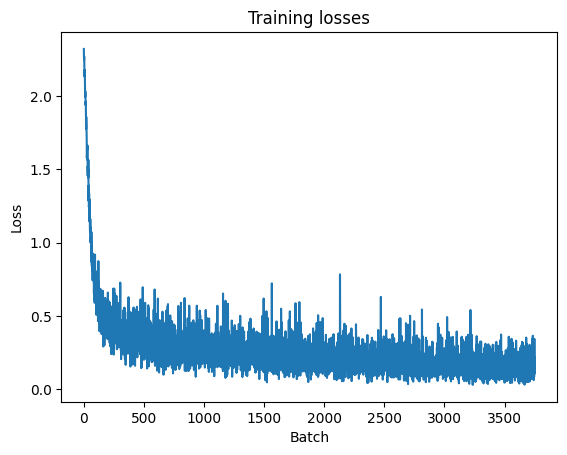

In [40]:
# plot training  losses
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training losses')
plt.plot(training_losses)

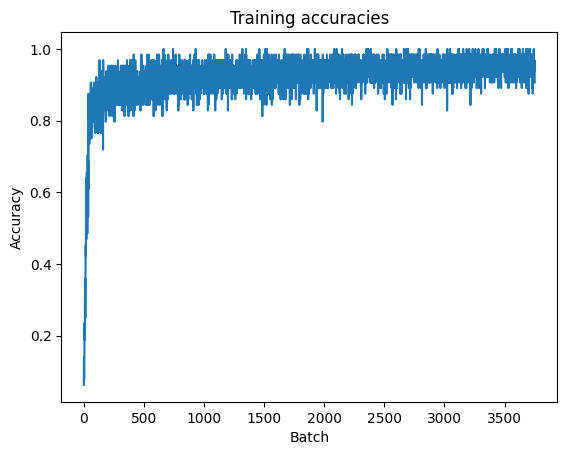

In [41]:
# plot training accuracies
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Training accuracies')
plt.plot(training_accuracies)

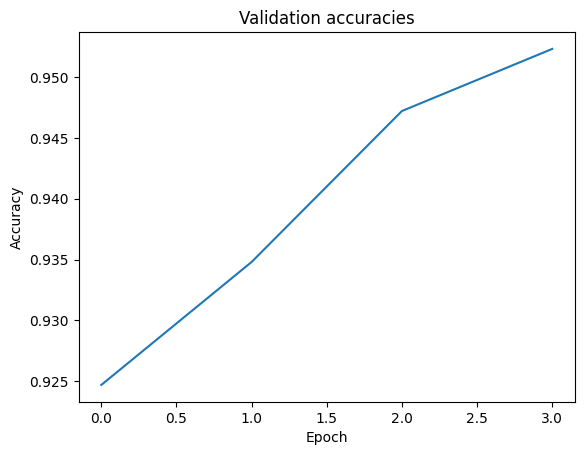

In [42]:
# plot validation accuracies
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation accuracies')
plt.plot(val_accuracies)


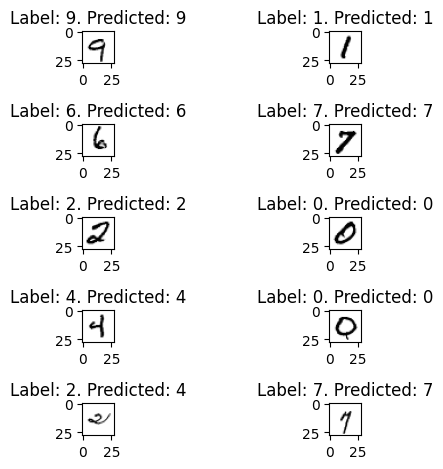

In [43]:
# Now we 'debug' some random samples, 
# by displaying the image, true label and predicted label
# (the predicted label is the one with highest output)
#
# Note that we use the train loader because that's the one which shuffles the data

for i in range(10):
    train_iter = iter(train_loader)
    images, labels = next(train_iter)

    # pick first entry of random batch
    input_img = images[0].to(device)
    true_label = labels[0].to(device)

    with torch.no_grad():
        output = best_model(input_img.view(-1,784))
        predicted_label = torch.argmax(output)
        # in a grid of subplots of size 5 x 2, select the (i+1)-th subplot 
        plt.subplot(5,2,i+1)
        plot_MNIST_pic(input_img, true_label.item(), predicted_label.item())
        
plt.tight_layout()

## Take this notebook further
Here are some possible ideas for you to try on your own:
* Define a new model. It'd be interesting to see how small the neural network can get before the performance drops dramatically on MNIST
* Play with the optimizer, e.g., 
    * what happens if we increase/decrease the learning rate a lot?
    * what's the performance of other optimizers? (see https://pytorch.org/docs/stable/optim.html)
    * what happens if we reduce the batch size, say to 4 or 8? (we should see more stochasticity in the loss)
